# This notebook performs the model training

We train here 2 models, a vanilla one that is a simple Bengio Language Model and the proposed one that is a GRU based Bengio Models with a VAE encoder after embedding.

## 0 - Defining parameters

In [1]:
## Global parameters (shared by both models)
BATCH_SIZE = 256
CONTEXT_SIZE = 5

## Vanilla model parameters
LR_VANILLA = 5e-3
HIDDEN_DIM_VANILLA = 128
EMBEDDING_DIM_VANILLA = 50
EPOCHS_VANILLA = 20

## Proposed model parameters
LR_MODEL = 5e-3
HIDDEN_DIM_MODEL = 128
EMBEDDING_DIM_MODEL = 50
EPOCHS_MODEL = 20

## 1 - Importing libbs

In [2]:
import pandas as pd
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import pickle
import umap
from src.train import *
import matplotlib.pyplot as plt
import random
import os
# from sklearn.manifold import TSNE
from openTSNE import TSNE

In [3]:
# Defining device type (you better have GPU to speed efficiency)
if torch.cuda.is_available(): 
    dev = "cuda:0"
else: 
    dev = "cpu"
device = torch.device(dev)
print('Using {}'.format(device))

Using cuda:0


## 2 - Reading trian and val dataset and turning in tensors

In [4]:
df_train_ = pd.read_csv("../data/df_train.csv", converters={'context': eval})
df_val_ = pd.read_csv("../data/df_val.csv", converters={'context': eval})

In [5]:
# Reading vocab and vocab_T
with open('obj/vocab.pkl', 'rb') as f:
    vocab = pickle.load(f)

with open('obj/vocab_t.pkl', 'rb') as f:
    vocab_t = pickle.load(f)
    
VOCAB_LEN = len(vocab)
print(VOCAB_LEN)

44900


In [6]:
# Transforming in torch tensors

# train
tensor_train = torch.tensor(df_train_.context.tolist(), dtype=torch.long)
tensor_target_train = torch.tensor(df_train_.target.tolist(), dtype=torch.long)
# valid
tensor_val = torch.tensor(df_val_.context.tolist(), dtype=torch.long)
tensor_target_val = torch.tensor(df_val_.target.tolist(), dtype=torch.long)

In [7]:
df_train = TensorDataset(tensor_train, tensor_target_train)
df_val = TensorDataset(tensor_val, tensor_target_val)

train_loader = DataLoader(df_train, batch_size = BATCH_SIZE, shuffle = True)
val_loader = DataLoader(df_val, batch_size = BATCH_SIZE, shuffle = False)

## 3 - Training models

### 3.1 - Vanilla model

In [8]:
# Defining vanilla model
model = BengioLModel(vocab_size = VOCAB_LEN, embedding_dim = EMBEDDING_DIM_VANILLA,
                    hidden_size = HIDDEN_DIM_VANILLA, context_size = CONTEXT_SIZE).to(device)

# Defining optimizer
opt = torch.optim.SGD(model.parameters(), LR_VANILLA, momentum=0.85)

# Defining loss function
loss_func = torch.nn.CrossEntropyLoss()

In [9]:
# Setting up seeds
seed = 42

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

# Training model

train_loss, val_loss, train_ppl, val_ppl = train(train_loader, val_loader, model,
                                                 epoch = EPOCHS_VANILLA, optimizer = opt, criterion = loss_func,
                                                 verbose = True, device = device, vocab = vocab)

EPOCH 1/20: trainning loss: 8.118476176378456 val loss: 8.244749580772178 | trainning ppl: 3355.903042504418 val ppl: 3807.5818469105798
EPOCH 2/20: trainning loss: 7.1953967056605945 val loss: 7.982767549533288 | trainning ppl: 1333.2791400702731 val ppl: 2930.0288533820403
EPOCH 3/20: trainning loss: 6.979589535580065 val loss: 7.850168948034638 | trainning ppl: 1074.4772417910792 val ppl: 2566.167829224535
EPOCH 4/20: trainning loss: 6.851757736454704 val loss: 7.765255717397894 | trainning ppl: 945.5414595297392 val ppl: 2357.2612041587063
EPOCH 5/20: trainning loss: 6.759831232716375 val loss: 7.7064538974206425 | trainning ppl: 862.496622293481 val ppl: 2222.6465343278687
EPOCH 6/20: trainning loss: 6.688810888546307 val loss: 7.659157169675364 | trainning ppl: 803.3663917663898 val ppl: 2119.9699004734052
EPOCH 7/20: trainning loss: 6.631408582363098 val loss: 7.625563193293451 | trainning ppl: 758.5498984824987 val ppl: 2049.9346494217
EPOCH 8/20: trainning loss: 6.583399745707

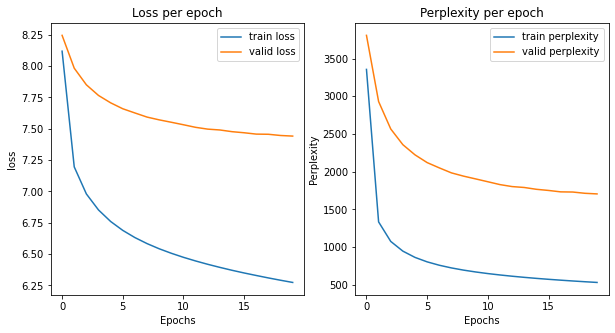

In [10]:
# Printing loss and perplexity

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,5))

# fig.set_title('Estado do modelo 10 épocas',fontsize= 25)

# plt.figure(figsize=(20,6))
ax1.set_title("Loss per epoch")
ax1.plot(train_loss, label = 'train loss')
ax1.plot(val_loss, label = 'valid loss')
ax1.set_xlabel("Epochs")
ax1.set_ylabel("loss")
ax1.legend()

# ax2.figure(figsize=(20,6))
ax2.set_title("Perplexity per epoch")
ax2.plot(train_ppl, label = 'train perplexity')
ax2.plot(val_ppl, label = 'valid perplexity')
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Perplexity")
ax2.legend()

plt.savefig("partial_results/vanilla_model_train_perplexity_graph.png", dpi=300)
plt.show()

In [11]:
# Visualyzing in lower dimension with umap
# Visualization in lower dimension
model.eval()

normalizador = 1

embeddings = []

with torch.no_grad():
  # Começo da avaliação em mini batches
  for x, y in val_loader:
    # Habilitando gpu 
    x = x.to(device)
    
    # Foward
    encoded = model.embedding(x)
    
    embeddings.extend(np.array(encoded.cpu().detach().tolist()))

In [12]:
for e in embeddings:
    if(type(e) != type(np.array([0]))):
        print(type(e))
# type(embeddings[0])

In [13]:
len(embeddings)

52336

In [14]:
reducer = TSNE(random_state = 42, n_iter = 250)

embeddings_train = reducer.fit(np.array(embeddings))

umaps = embeddings_train.transform(np.array(embeddings))

umaps.shape

(52336, 2)

In [15]:
umap_df = pd.DataFrame({'u1': umaps[:,0], 'u2': umaps[:,1], 'targets': df_val_.author})
umap_df.head()

,u1,u2,targets
0,-40.137680,12.732701,44897
1,-17.518586,-24.177909,44897
2,-10.820831,-22.921235,44899
3,11.758461,8.368583,44897
4,35.355739,7.267729,44897


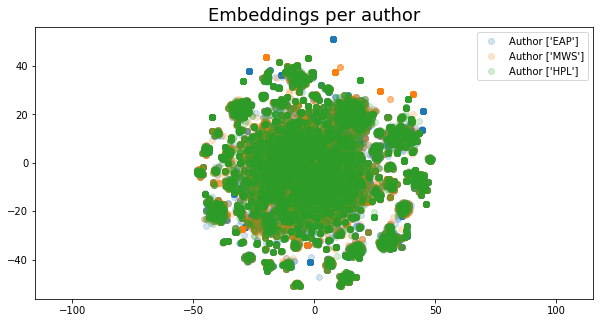

In [16]:
plt.figure(figsize = (10,5))
# plt.scatter(umaps[:, 0], umaps[:, 1], c=[sns.color_palette()[x] for x in np.array(targets_val).astype(int)])

for t in np.unique(df_val_.author):
  # if(t in [2,6]):
  plt.scatter(umap_df[umap_df.targets == t]['u1'], umap_df[umap_df.targets == t]['u2'], alpha =  0.2, label = f'Author {vocab_t[t]}')
  # plt.scatter(centroids[centroids['target'] == t]['x'],centroids[centroids['target'] == t]['y'], linewidths=5,label = f'CENTROID Emotion {map_emotion(t)}')
  
plt.legend()

plt.gca().set_aspect('equal', 'datalim')
plt.savefig("partial_results/vanilla_model_umap_embedding.png", dpi = 300)
plt.title('Embeddings per author', fontsize=18);

### 3.2 - Proposed model

In [17]:
# Defining proposed model
model = ProposedModel(vocab_size = VOCAB_LEN, embedding_dim = EMBEDDING_DIM_MODEL,
                    hidden_size = HIDDEN_DIM_MODEL, context_size = CONTEXT_SIZE).to(device)

# Defining optimizer
opt = torch.optim.SGD(model.parameters(), LR_MODEL, momentum=0.85)

# Defining loss function
loss_func = torch.nn.CrossEntropyLoss()

In [18]:
# Setting up seeds
seed = 42

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

# Training model

train_loss, val_loss, train_ppl, val_ppl = train(train_loader, val_loader, model,
                                                 epoch = EPOCHS_MODEL, optimizer = opt, criterion = loss_func,
                                                 verbose = True, device = device, vocab = vocab)

EPOCH 1/20: trainning loss: 7.664638136470532 val loss: 7.900509822715834 | trainning ppl: 2131.6212863659966 val ppl: 2698.65781466779
EPOCH 2/20: trainning loss: 6.939497368546817 val loss: 7.730251849276348 | trainning ppl: 1032.2512426032906 val ppl: 2276.175381729415
EPOCH 3/20: trainning loss: 6.792171116693715 val loss: 7.638335621472701 | trainning ppl: 890.8455934781525 val ppl: 2076.2852146305936
EPOCH 4/20: trainning loss: 6.705031891221394 val loss: 7.589404138546546 | trainning ppl: 816.5040652091991 val ppl: 1977.1350641116367
EPOCH 5/20: trainning loss: 6.645829676027728 val loss: 7.560301134887251 | trainning ppl: 769.5682751839332 val ppl: 1920.4237328924337
EPOCH 6/20: trainning loss: 6.600977039544366 val loss: 7.5292006650017305 | trainning ppl: 735.8137572882715 val ppl: 1861.616853166494
EPOCH 7/20: trainning loss: 6.565203441607441 val loss: 7.511794877283782 | trainning ppl: 709.9563161600893 val ppl: 1829.4943154312912
EPOCH 8/20: trainning loss: 6.534233842577

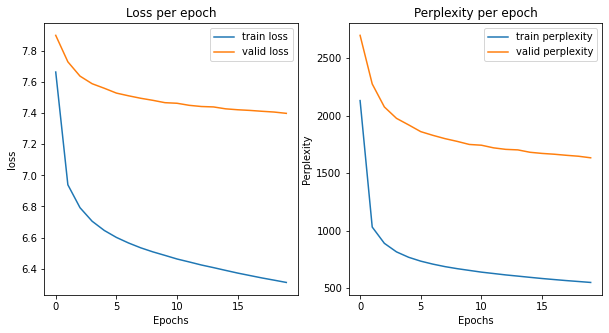

In [19]:
# Printing loss and perplexity

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,5))

# fig.set_title('Estado do modelo 10 épocas',fontsize= 25)

# plt.figure(figsize=(20,6))
ax1.set_title("Loss per epoch")
ax1.plot(train_loss, label = 'train loss')
ax1.plot(val_loss, label = 'valid loss')
ax1.set_xlabel("Epochs")
ax1.set_ylabel("loss")
ax1.legend()

# ax2.figure(figsize=(20,6))
ax2.set_title("Perplexity per epoch")
ax2.plot(train_ppl, label = 'train perplexity')
ax2.plot(val_ppl, label = 'valid perplexity')
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Perplexity")
ax2.legend()

plt.savefig("partial_results/proposed_model_train_perplexity_graph.png", dpi=300)
plt.show()

In [36]:
# Visualyzing in lower dimension with umap
# Visualization in lower dimension
model.eval()

normalizador = 1

embeddings = []

with torch.no_grad():
  # Começo da avaliação em mini batches
  for x, y in val_loader:
    # Habilitando gpu 
    x = x.to(device)
    
    # Foward
    encoded = model.embedding(x)
    
    embeddings.extend(np.array(encoded.contiguous().view(-1, CONTEXT_SIZE*HIDDEN_DIM_MODEL).cpu().detach().tolist()))

In [37]:
reducer = TSNE(random_state = 42, n_iter = 250)

embeddings_train = reducer.fit(np.array(embeddings))

umaps = embeddings_train.transform(np.array(embeddings))

umaps.shape

(52336, 2)

In [38]:
umap_df = pd.DataFrame({'u1': umaps[:,0], 'u2': umaps[:,1], 'targets': df_val_.author})
umap_df.head()

,u1,u2,targets
0,5.849376,-19.119596,44897
1,36.993955,-18.956884,44897
2,-22.964472,0.563131,44899
3,2.807555,44.617603,44897
4,-8.438979,19.705772,44897


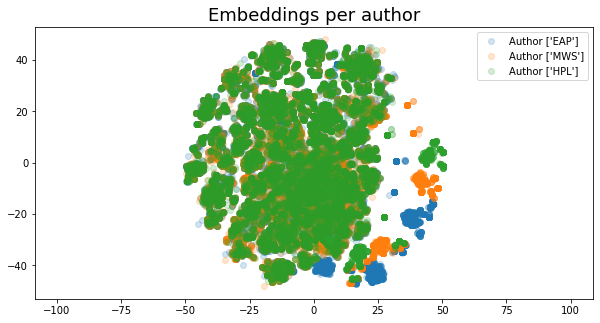

In [39]:
plt.figure(figsize = (10,5))
# plt.scatter(umaps[:, 0], umaps[:, 1], c=[sns.color_palette()[x] for x in np.array(targets_val).astype(int)])

for t in np.unique(df_val_.author):
  # if(t in [2,6]):
  plt.scatter(umap_df[umap_df.targets == t]['u1'], umap_df[umap_df.targets == t]['u2'], alpha =  0.2, label = f'Author {vocab_t[t]}')
  # plt.scatter(centroids[centroids['target'] == t]['x'],centroids[centroids['target'] == t]['y'], linewidths=5,label = f'CENTROID Emotion {map_emotion(t)}')
  
plt.legend()

plt.gca().set_aspect('equal', 'datalim')
plt.savefig("partial_results/proposed_model_umap_embedding.png", dpi = 300)
plt.title('Embeddings per author', fontsize=18);